In [1]:
import requests
import zipfile
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from cycler import cycler

plt.rcParams['figure.dpi']     = 100
plt.rcParams['figure.figsize'] = 15,12
plt.rcParams['axes.prop_cycle'] = cycler('color', ['cadetblue','orangered','gold', 'navy'])

pobanie oraz rozpakowanie danych do katalogu ..\dane\

In [2]:
r = requests.get('https://arcgis.com/sharing/rest/content/items/a8c562ead9c54e13a135b02e0d875ffb/data')
zawartosc = r.content

with open('dane//dane.zip', 'wb') as plik:
    plik.write(zawartosc)

with zipfile.ZipFile('dane//dane.zip') as spaklowany_plik:
    spaklowany_plik.extractall(pathlib.Path('dane/pliki'))

lista_plikow = list(pathlib.Path.glob(pathlib.Path('dane/pliki'), '*.csv'))


mielonka

In [3]:
arch_data0 = pd.read_csv(pathlib.Path('dane/mat_arch.csv'), sep = ';',decimal=' ', encoding= 'windows-1250')
arch_data = pd.DataFrame()
arch_data['Data'] = pd.to_datetime(arch_data0['Data'], format='%d.%m.%Y')
arch_data['Liczba Przypadkow'] = arch_data0['Nowe przypadki'].astype('int')
arch_data.index = arch_data['Data']
arch_data0['Data'] = pd.to_datetime(arch_data0['Data'], format='%d.%m.%Y')

zgony0 = pd.DataFrame()
zgony0['Data']  = pd.to_datetime(arch_data0['Data'], format='%d.%m.%Y')
zgony0['zgony'] = arch_data0['Zgony'].astype('int')

nazwy_kolumn =['zgony', 'zgony_w_wyniku_covid_bez_chorob_wspolistniejacych','zgony_w_wyniku_covid_i_chorob_wspolistniejacych']
zgony1 = {'Data':[], 'zgony':[], 'zgony_w_wyniku_covid_bez_chorob_wspolistniejacych':[],'zgony_w_wyniku_covid_i_chorob_wspolistniejacych':[]}
for i, _ in enumerate(lista_plikow):
    odczytane_dane= pd.read_csv(lista_plikow[i], sep = ';',decimal=' ', encoding= 'windows-1250')

    zgony1['Data'].append(pd.to_datetime(str(lista_plikow[i])[11:19],format='%Y%m%d'))
    zgony1[nazwy_kolumn[0]].append(odczytane_dane.loc[0,'zgony'])
    zgony1[nazwy_kolumn[1]].append(odczytane_dane.loc[0,nazwy_kolumn[1]])
    zgony1[nazwy_kolumn[2]].append(odczytane_dane.loc[0,nazwy_kolumn[2]])

zgony1 = pd.DataFrame(zgony1, index = zgony1['Data'])
zgony1.columns = ['Data', 'zgony', 'zgony_w_wyniku_covid_bez_chorob_wspolistniejacych','zgony_w_wyniku_covid_i_chorob_wspolistniejacych']
zgony1 = pd.concat([zgony0,zgony1])
zgony1.index = zgony1['Data']

nazwa_kolumny = ['liczba_wszystkich_zakazen', 'liczba_nowych_zakazen', 'liczba_ponownych_zakazen']
przypadki = {'Data': [], 'liczba_wszystkich_zakazen' :[], 'liczba_nowych_zakazen': [], 'liczba_ponownych_zakazen': []}


for i, _ in enumerate(lista_plikow):
    odczytane_dane= pd.read_csv(lista_plikow[i], sep = ';',decimal=' ', encoding= 'windows-1250')
    przypadki['Data'].append(pd.to_datetime(str(lista_plikow[i])[11:19],format='%Y%m%d'))
    if 'liczba_przypadkow' in odczytane_dane.columns.values:
        przypadki[nazwa_kolumny[0]].append(odczytane_dane.loc[0,'liczba_przypadkow'])
        przypadki[nazwa_kolumny[1]].append(np.nan)
        przypadki[nazwa_kolumny[2]].append(np.nan)

    else:
        przypadki[nazwa_kolumny[0]].append(odczytane_dane.loc[0,nazwa_kolumny[0]])
        przypadki[nazwa_kolumny[1]].append(odczytane_dane.loc[0,nazwa_kolumny[1]])
        przypadki[nazwa_kolumny[2]].append(odczytane_dane.loc[0,nazwa_kolumny[2]])

przypadki = pd.DataFrame(przypadki)

nazwa_kolumny = ['liczba_wszystkich_zakazen', 'liczba_nowych_zakazen', 'liczba_ponownych_zakazen']

przypadki0 = pd.DataFrame()
przypadki0['Data'] = arch_data0['Data']
przypadki0['liczba_wszystkich_zakazen'] = arch_data0['Nowe przypadki']

przypadki1 = pd.concat([przypadki0, przypadki])
przypadki1.index = przypadki1['Data']



przypadki_woj = []
for i, _ in enumerate(lista_plikow):
    odczytane_dane= pd.read_csv(lista_plikow[i], sep = ';',decimal=' ', encoding= 'windows-1250', index_col='teryt')
    if 'liczba_przypadkow' in odczytane_dane.columns :
        przypadki_woj.append(pd.read_csv(lista_plikow[i], sep = ';',decimal=' ', encoding= 'windows-1250',index_col='teryt').loc['t02':'t32',['liczba_przypadkow']].transpose())
    else:
        przypadki_woj.append(pd.read_csv(lista_plikow[i], sep = ';',decimal=' ', encoding= 'windows-1250',index_col='teryt').loc['t02':'t32',['liczba_nowych_zakazen']].transpose())
przypadki_woj1 = pd.concat(przypadki_woj)
przypadki_woj1 = przypadki_woj1.astype('int16')

zgony_woj = []
for i, _ in enumerate(lista_plikow):
    odczytane_dane = pd.read_csv(lista_plikow[i], sep = ';',decimal=' ', encoding= 'windows-1250', index_col='teryt')
    zgony_woj.append(odczytane_dane.loc['t02':'t32',['zgony']].transpose())
zgony_woj1 = pd.concat(zgony_woj)

woj_labels = odczytane_dane['wojewodztwo'].values
zgony_woj  = zgony_woj1.astype('float16')

visualizacja

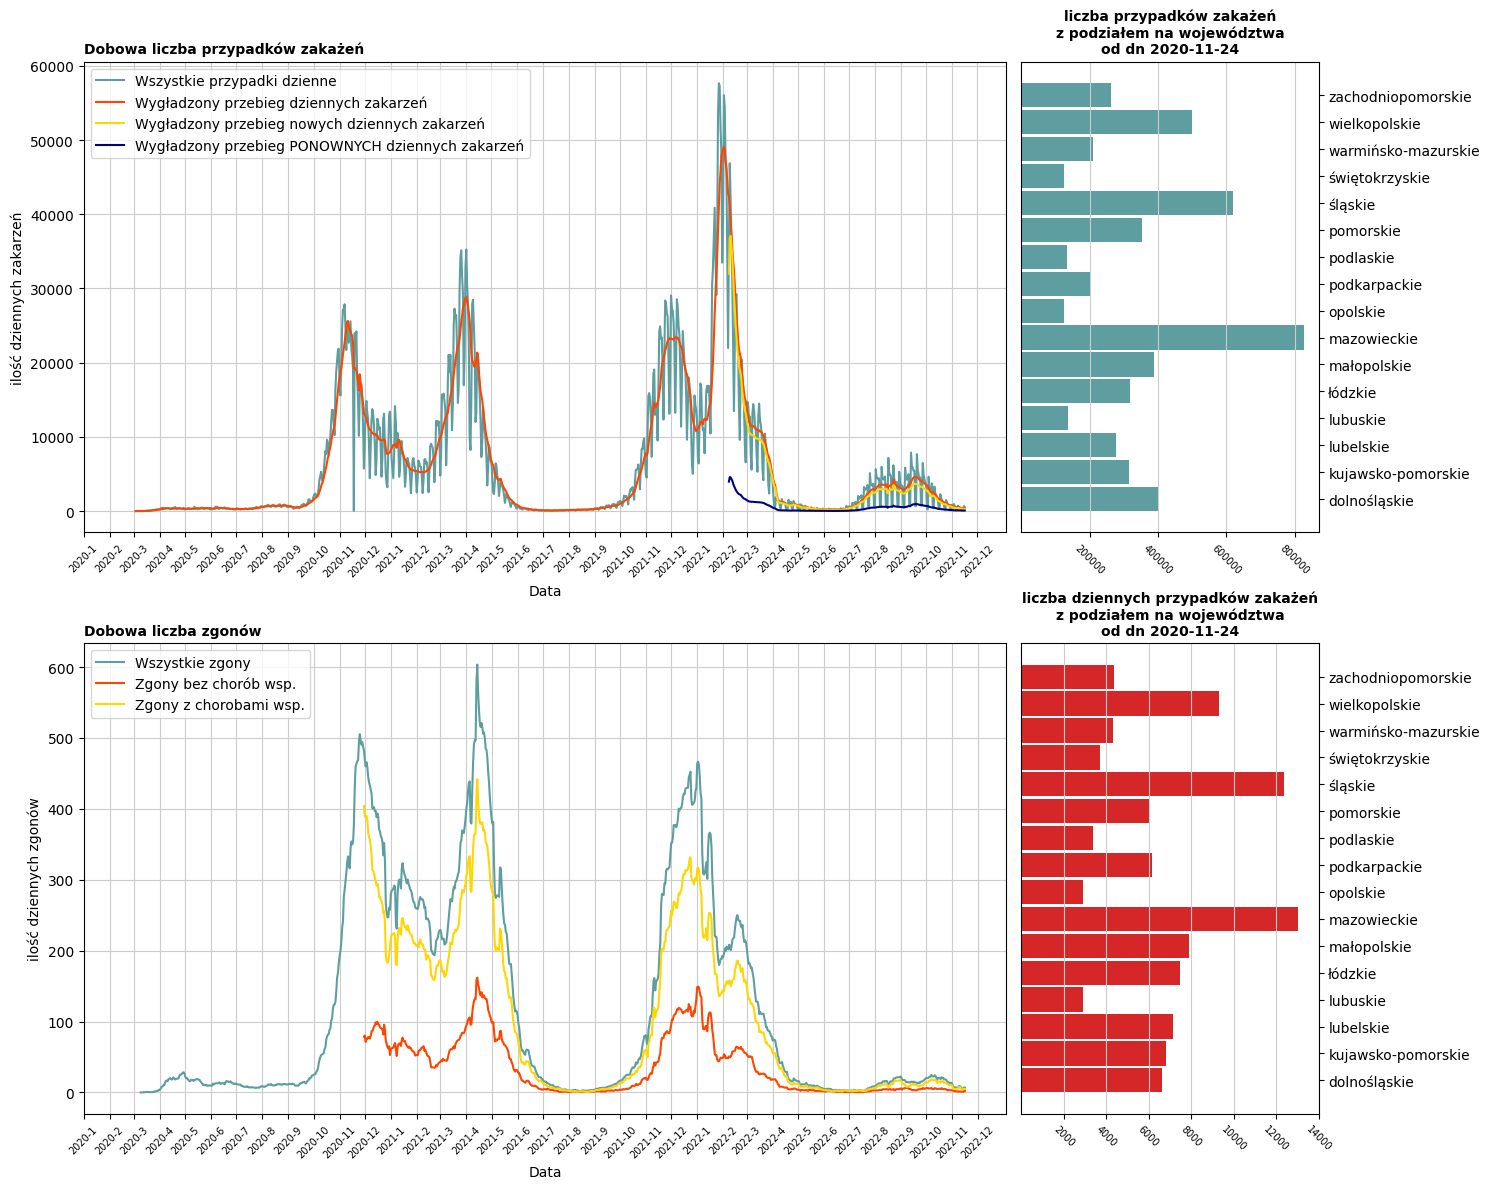

In [4]:
fig, axs = plt.subplot_mosaic(mosaic="""
AAAC
BBBD
""")

sns.lineplot(data = przypadki1, x = przypadki1['Data'], y = 'liczba_wszystkich_zakazen', ax = axs['A'], label = 'Wszystkie przypadki dzienne')
sns.lineplot(data = przypadki1.rolling(window = 7,min_periods = 1).mean(), x = przypadki1['Data'], y = 'liczba_wszystkich_zakazen', ax = axs['A'], label = 'Wygładzony przebieg dziennych zakarzeń')
sns.lineplot(data = przypadki1.rolling(window = 7,min_periods = 1).mean(), x = przypadki1['Data'], y = 'liczba_nowych_zakazen', ax = axs['A'], label = 'Wygładzony przebieg nowych dziennych zakarzeń')
sns.lineplot(data = przypadki1.rolling(window = 7,min_periods = 1).mean(), x = przypadki1['Data'], y = 'liczba_ponownych_zakazen', ax = axs['A'], label = 'Wygładzony przebieg PONOWNYCH dziennych zakarzeń')

axs['A'].set_xticks(pd.to_datetime([f'{yr}-{mo}-01' for mo in range(1,13) for yr in range(2020, 2023)]))
axs['A'].set_xticklabels(rotation = 45, size = 7, labels = [f'{yr}-{mo}' for mo in range(1,13) for yr in range(2020, 2023)])
axs['A'].set_ylabel('ilość dziennych zakarzeń')
axs['A'].grid(axis = 'both', c = '0.80')
axs['A'].set_title('Dobowa liczba przypadków zakażeń', fontdict = {'fontsize' : 10, 'weight' : 'bold'}, loc = 'left')

sns.lineplot(data = zgony1.rolling(window = 7).mean(), x = 'Data', y = 'zgony', legend = True, ax = axs['B'], label = 'Wszystkie zgony')
sns.lineplot(data = zgony1.rolling(window = 7).mean(), x = 'Data', y = 'zgony_w_wyniku_covid_bez_chorob_wspolistniejacych', legend = True, ax = axs['B'], label = 'Zgony bez chorób wsp.')
sns.lineplot(data = zgony1.rolling(window = 7).mean(), x = 'Data', y = 'zgony_w_wyniku_covid_i_chorob_wspolistniejacych', legend = True, ax = axs['B'], label = 'Zgony z chorobami wsp.')

axs['B'].set_xticks(pd.to_datetime([f'{yr}-{mo}-01' for mo in range(1,13) for yr in range(2020, 2023)]))
axs['B'].set_xticklabels(rotation = 45, size = 7, labels = [f'{yr}-{mo}' for mo in range(1,13) for yr in range(2020, 2023)])
axs['B'].legend(fontsize =  10, loc = 2)
axs['B'].set_ylabel('ilość dziennych zgonów')
axs['B'].grid(axis = 'both', c = '0.80')
axs['B'].set_title('Dobowa liczba zgonów', fontdict = {'fontsize' : 10, 'weight' : 'bold'}, loc = 'left')


axs['C'].barh(y = [x for x in range(1,17)], width = przypadki_woj1.sum(), height = 0.9)
axs['C'].set_yticks([x for x in range(1,17)])
axs['C'].yaxis.tick_right()
axs['C'].set_yticklabels(woj_labels[1:])
axs['C'].set_xticks(ticks = [x*200000 for x in range(1, 5)])
axs['C'].set_xticklabels(rotation = -45,size = 7, labels = [x*200000 for x in range(1,5)])
axs['C'].grid(axis = 'x', c = '0.80' )
axs['C'].set_title(f'liczba przypadków zakażeń\nz podziałem na województwa\nod dn {przypadki["Data"][0].strftime("%Y-%m-%d")}', fontdict = {'fontsize' : 10, 'weight' : 'bold'})

axs['D'].barh(y = [x for x in range(1,17)], width = zgony_woj.sum(), height = 0.9, color = 'tab:red')
axs['D'].set_yticks([x for x in range(1,17)])
axs['D'].yaxis.tick_right()
axs['D'].set_yticklabels(woj_labels[1:])
axs['D'].set_xticks(ticks = [x*2000 for x in range(1, 8)])
axs['D'].set_xticklabels(rotation = -45,size = 7, labels = [x*2000 for x in range(1, 8)])
axs['D'].grid(axis = 'x', c = '0.80' )
axs['D'].set_title(f'liczba dziennych przypadków zakażeń\nz podziałem na województwa\nod dn {przypadki["Data"][0].strftime("%Y-%m-%d")}', fontdict = {'fontsize' : 10, 'weight' : 'bold'})

plt.tight_layout()

plt.show()